# 预处理

在预处理数据之前，先对spaceship_titanic_exploration.ipynb数据探索作简单整理
## 已知
* PassengerId/HomePlanet/Cabin/Destination/Name

        PassengerId是顾客的标识符，由(组_组内号)表示，同一组的乘客一般为一家人；HomePlanet是家乡；Cabin是deck/num/side，处理方法需要参考；Destination是目的地，一家人、一组人的目的地是否一致？；Name是乘客姓名，对分类意义不大
* Age

        Age是乘客的年龄，是纯数值，不天生具有正态分布
* CryoSleep/VIP

        CryoSleep-是否睡在冷冻仓，是bool值，经过观察，在不在冷冻都有概率传送走；VIP-是否为会员，是bool值，VIP数量很少
* RoomService/FoodCourt/ShoppingMall/Spa/VRDeck

        开销，开销的呈现形式非常零散，而开销总和是应该被计算的
* 总结


        在两份数据集的完整度上，由于PassengerId是完整的，因此在缺失值填充的过程中应该优先考虑组，

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train_path = "D:/temp_files/datasets/spaceship_titanic/train.csv"
test_path = "D:/temp_files/datasets/spaceship_titanic/test.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train = train.drop(axis=1, labels='Name')
test = test.drop(axis=1, labels='Name')

## 缺失值填充

HomePlanet/Destination一律用

In [2]:
print(train.HomePlanet.value_counts())
print(train.Destination.value_counts())

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


In [3]:
train.HomePlanet.fillna(value='Earth', inplace=True)
train.Destination.fillna(value='TRAPPIST-1e', inplace=True)
test.HomePlanet.fillna(value='Earth', inplace=True)
test.Destination.fillna(value='TRAPPIST-1e', inplace=True)
def dest(row):
    if row == 'TRAPPIST-1e':
        return 'T'
    elif row == '55 Cancri e':
        return 'C'
    else:
        return 'P'
train.Destination = train.Destination.apply(dest)
test.Destination = test.Destination.apply(dest)

In [4]:
train.Age.fillna(value=train.Age.mean(), inplace=True)
test.Age.fillna(value=test.Age.mean(), inplace=True)
train['Total'] = 0
test['Total'] = 0
services = "RoomService/FoodCourt/ShoppingMall/Spa/VRDeck".split("/")
for service in services:
    train[service].fillna(value=train[service].mean(), inplace=True)
    test[service].fillna(value=test[service].mean(), inplace=True)
    train['Total'] = train['Total'] + train[service]
    test['Total'] = test['Total'] + test[service]
train.Total = train.Total.apply(lambda x : round(x))
test.Total = test.Total.apply(lambda x : round(x))

In [5]:
print(train.CryoSleep.value_counts())
print(train.VIP.value_counts())
print(test.CryoSleep.value_counts())
print(test.VIP.value_counts())

False    5439
True     3037
Name: CryoSleep, dtype: int64
False    8291
True      199
Name: VIP, dtype: int64
False    2640
True     1544
Name: CryoSleep, dtype: int64
False    4110
True       74
Name: VIP, dtype: int64


In [6]:
train.VIP.fillna(value=False, inplace=True)
train.CryoSleep.fillna(value=False, inplace=True)
test.VIP.fillna(value=False, inplace=True)
test.CryoSleep.fillna(value=False, inplace=True)

In [7]:
train.Cabin = train.Cabin.astype(str)
test.Cabin = test.Cabin.astype(str)

In [8]:
def deck(row):
    # nan在类型转换后会变成字符串"nan"
    # 不能被fillna检测
    if row == "nan":
        return
    a = row.split("/")
    return a[0]
def side(row):
    if row == "nan":
        return
    a = row.split("/")
    return a[2]
train['Deck'] = train.Cabin.apply(deck)
train['Side'] = train.Cabin.apply(side)
test['Deck'] = train.Cabin.apply(deck)
test['Side'] = train.Cabin.apply(side)

In [9]:
print(train.Deck.value_counts())
print(train.Side.value_counts())
print(test.Deck.value_counts())
print(test.Side.value_counts())

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64
S    4288
P    4206
Name: Side, dtype: int64
F    1340
G    1274
E     427
B     389
C     349
D     260
A     121
T       4
Name: Deck, dtype: int64
S    2104
P    2060
Name: Side, dtype: int64


In [10]:

train.Deck.fillna(value='F', inplace=True)
train.Side.fillna(method='pad', inplace=True)
test.Deck.fillna(value='F', inplace=True)
test.Side.fillna(method='pad', inplace=True)

In [11]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Transported   8693 non-null   bool   
 13  Total         8693 non-null   int64  
 14  Deck          8693 non-null   object 
 15  Side          8693 non-null   object 
dtypes: bool(3), float64(6), int64(1), object(6)
memory usage: 908.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Ran

In [12]:
features = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Total', 'Deck', 'Side']
test_full = test.loc[:, features]
features.append("Transported")
train_full = train.loc[:, features]

数据可视化

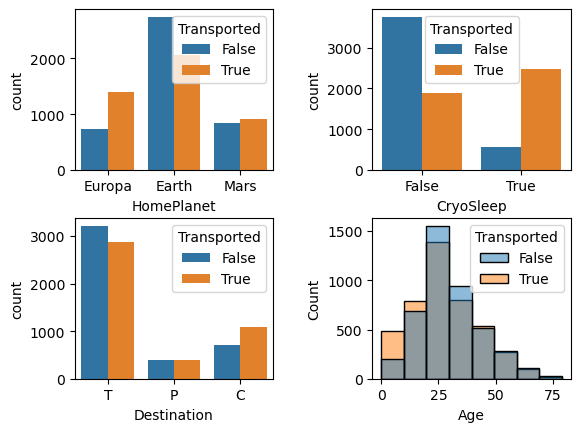

In [13]:
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.subplot(2,2,1)
sns.countplot(data=train_full, x='HomePlanet', hue='Transported')
plt.subplot(2,2,2)
sns.countplot(data=train_full, x='CryoSleep', hue='Transported')
plt.subplot(2,2,3)
sns.countplot(data=train_full, x='Destination', hue='Transported')
plt.subplot(2,2,4)
sns.histplot(data=train_full, x='Age', bins=8, hue='Transported')
plt.show()

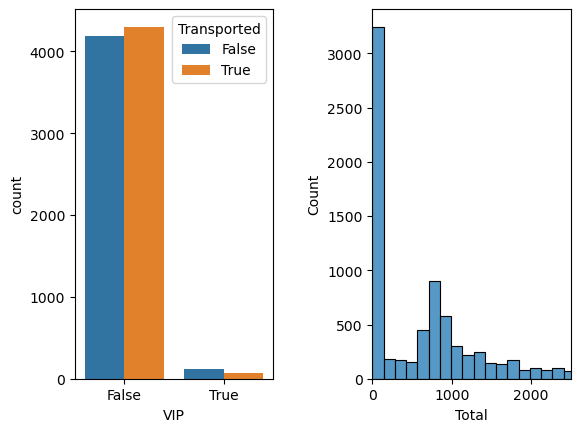

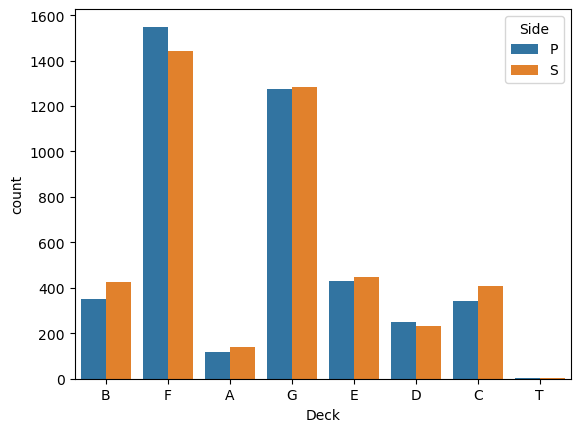

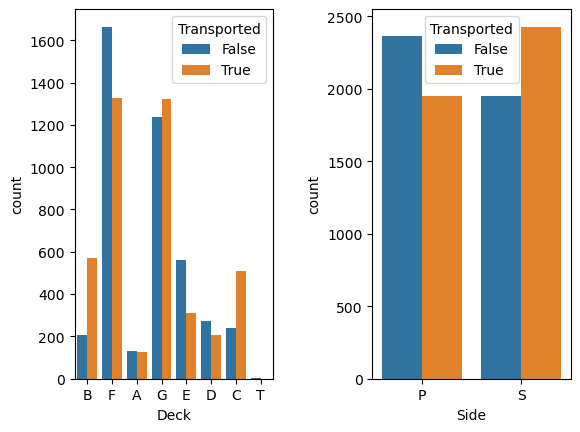

In [38]:
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.subplot(1,2,1)
sns.countplot(data=train_full, x='VIP', hue='Transported')
plt.subplot(1,2,2)
plt.xlim(0,2500)
plt.ylim()
sns.histplot(data=train_full, x='Total')
plt.show()
sns.countplot(data=train_full, x='Deck', hue='Side')
plt.show()
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.subplot(1,2,1)
sns.countplot(data=train_full, x='Deck', hue='Transported')
plt.subplot(1,2,2)
sns.countplot(data=train_full, x='Side', hue='Transported')
plt.show()